# Financial auditing 📊

### This notebook will provide a proof of concept on the financial auditing workflow designed by team **Cydra Tech**

<br>

## Workflow steps
1. Create an agent that has capabilites to analyze structured and unstructred data
    - For structured data we can use sql
    - For unstructured data we can use RAG 
2. Data Preparation
    - Data to be audited can be structured, unstructured or mix of both
3. Generate sub-reports
    - The agent now has enough capabilties for analysis and can be invoked to perform the audit
    - invoke it `n` times to generate a diverse set of sub-reports
4. Generate final report
    - Condense the `n` sub-reports to generate the final report containing all the needed info.

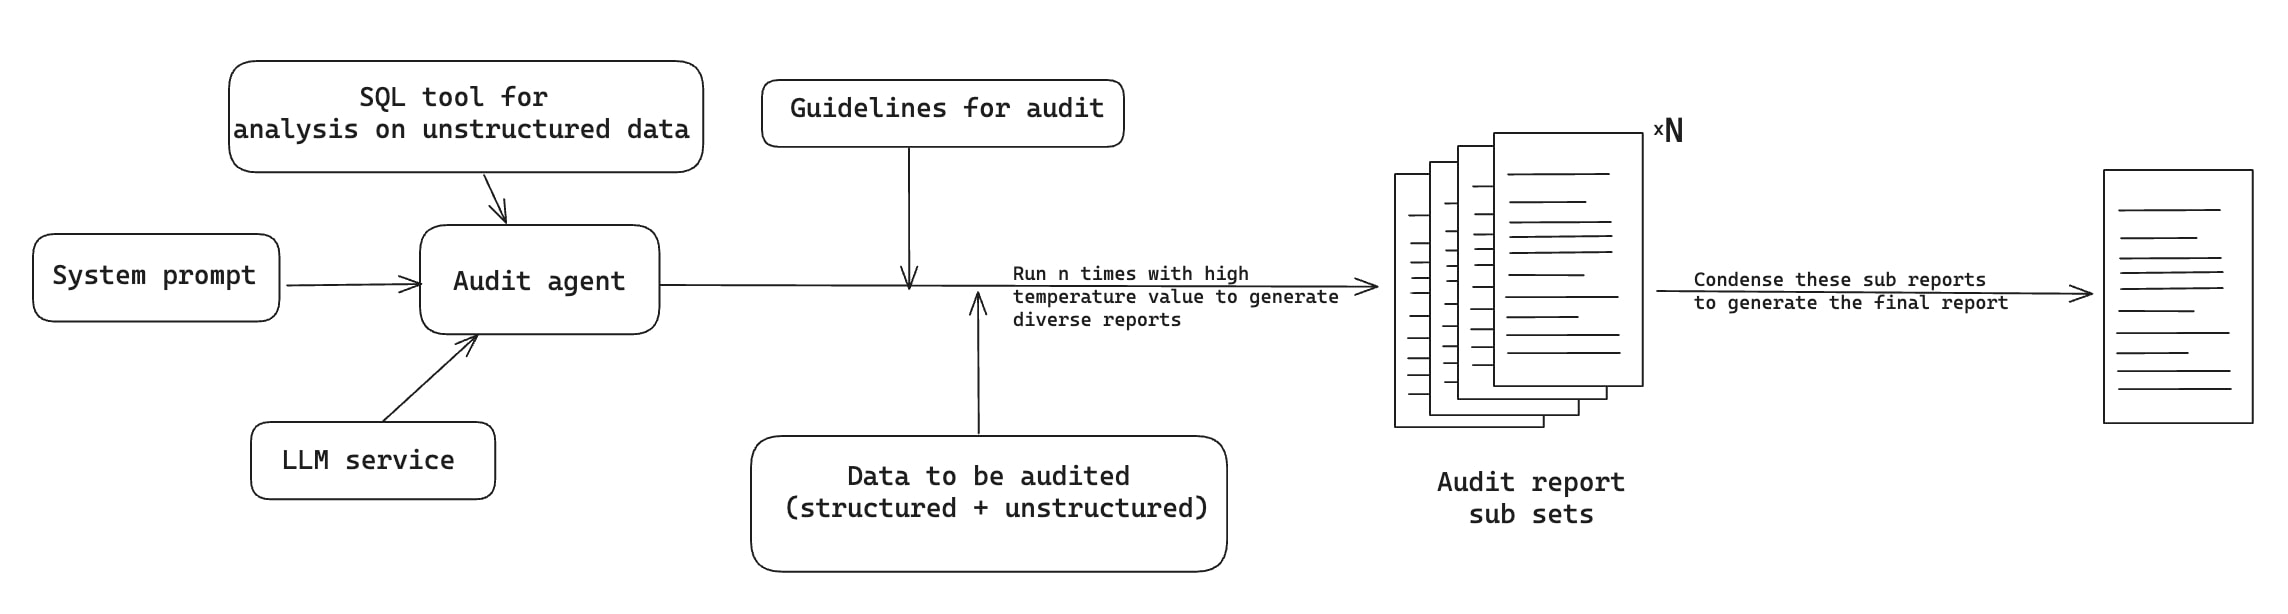

In [8]:
!pip install langchain langchain-community langchain-experimental langchain-openai langchain-core openai pandas pydantic


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: pip install --upgrade pip


### Before we start coding kindly fill out your azure openai base url and api key

In [3]:
base_url : str = ''
api_key: str = ''

# 1. Agent creation

#### The agent will need to use the sql tool to analyze structured data so lets first create that

In [4]:
from langchain.tools import Tool
import pandasql as pdsql
import pandas as pd
from pydantic.v1 import BaseModel, Field  # v1 bc v2 is not supported by langchain
from langchain_experimental.utilities import PythonREPL
from typing import Dict



class QueryTablesArgsSchema(BaseModel):
    query: str = Field(
        name="query",
        title="Query",
        description="The SQL query to execute",
    )


class QueryTables:
    """
    A class that represents a collection of tables and provides a method to execute SQL queries on those tables.

    Attributes:
        name (str): The name of the QueryTables instance.
        description (str): A description of the QueryTables instance.
        args_schema (QueryTablesArgsSchema): The argument schema for the QueryTables instance.
        tables (Dict[str, pd.DataFrame]): A dictionary of table names and corresponding DataFrames.

    Methods:
        __call__(query: str) -> str: Executes the given SQL query on the tables and returns the result.

    """

    def __init__(self, tables: Dict[str, pd.DataFrame]) -> None:
        self.name = "QueryTables"
        self.description = """Given a SQL query, returns the result of the query."""
        self.args_schema = QueryTablesArgsSchema
        self.tables = tables

    def __call__(
        self,
        query: str,
    ) -> str:
        """
        Executes the given SQL query on the tables and returns the result.

        Args:
            query (str): The SQL query to execute.

        Returns:
            str: The result of the query.

        """
        # print(query)
        try:
            result = pdsql.sqldf(query, self.tables)
            return result
        except Exception as e:
            print(e)
            return f"Error executing query: {e}"
        

# for mathematical calculations
class PythonREPLTool:
    def __init__(self):
        self.name = "python_repl"
        self.description = "A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`."
        self.tool = PythonREPL()

    def __call__(self, arg):
        return self.tool.run(arg)

#### Now lets build an agent abstraction that has access to tools

In [5]:
from langchain.schema import SystemMessage

from langchain_openai import ChatOpenAI
from langchain.chains.conversation.memory import (
    ConversationBufferMemory,
)
from langchain.agents import OpenAIFunctionsAgent
from langchain.prompts import MessagesPlaceholder
from langchain.agents import AgentExecutor
from langchain_experimental.utilities import PythonREPL
from typing import List, Optional, Callable


class BaseAgent:

    def __init__(
        self,
        system_messge: SystemMessage,
        tools: List[Callable],
        history: Optional[bool] = False,
    ):
        """
        Initializes an instance of the BaseAgent class.

        Args:
            system_messge (SystemMessage): The system message to be used in the conversation prompt.
            tools (List[Callable]): A list of tools (callables) to be used in the agent.
            history (Optional[bool], optional): Flag indicating whether to enable conversation history. Defaults to False.
        """
        self.tools = tools
        self.llm = ChatOpenAI(
            base_url=base_url,
            api_key=api_key,
            temperature=1,
            model="gpt-4-turbo",
        )

        python_repl = PythonREPLTool()

        python_reply_tool = Tool.from_function(
            func=python_repl,
            name=python_repl.name,
            description=python_repl.description,
        )

        self.tools.append(python_reply_tool)  # For mathematical calculations

        if history:
            self.agent_kwargs = {
                "extra_prompt_messages": [MessagesPlaceholder(variable_name="memory")]
            }

            memory = ConversationBufferMemory(
                llm=self.llm,
                memory_key="memory",
                return_messages=True,
            )

            self.prompt = OpenAIFunctionsAgent.create_prompt(
                system_message=system_messge,
                extra_prompt_messages=[MessagesPlaceholder(variable_name="memory")],
            )
        else:
            memory = None
            self.prompt = OpenAIFunctionsAgent.create_prompt(
                system_message=system_messge,
            )

        agent = OpenAIFunctionsAgent(
            llm=self.llm,
            tools=self.tools,
            prompt=self.prompt,
        )
        self.agent_executor = AgentExecutor(
            agent=agent,
            tools=self.tools,
            # verbose=True,
            memory=memory,
            max_iterations=20,
            max_execution_time=520,
            handle_parsing_errors=True,
        )

    def run(self, query: str) -> str:
        """
        Executes the given prompt and returns the response.

        Args:
            query (str): The prompt query.

        Returns:
            str: The prompt response.
        """
        response = self.agent_executor.invoke(query)
        return response["output"]

    async def arun(self, query: str):
        """async version of the `run` func"""
        response = await self.agent_executor.arun(query)
        return response["output"]

#### Create an audit agent based on the agent abstraction

In [6]:


def generateDfDescription(df: pd.DataFrame, df_name: str) -> str:
    """
    Generate a description of a DataFrame. Useful for LLM to infer the data it needs to analyse.

    Args:
        df (pd.DataFrame): The DataFrame to generate the description for.
        df_name (str): The name of the DataFrame.

    Returns:
        str: The generated description of the DataFrame.
    """

    description = f"Table: {df_name} (row count: {len(df)})\ncolumns:\n"

    for col, dtype in zip(df.columns, df.dtypes):
        if dtype == "object":
            description += f"\t {col} [string]\n"
        else:
            description += f"\t {col} [{dtype}]\n"
    return description


def getAuditAgent(
    guidelines: str,
    documents: str,
    tables: Dict[str, pd.DataFrame],
) -> BaseAgent:
    query_tables = QueryTables(tables)

    query_tables_tool = Tool.from_function(
        func=query_tables,
        name=query_tables.name,
        description=query_tables.description,
        args_schema=query_tables.args_schema,
    )

    table_descriptions = [
        generateDfDescription(df, df_name) for df_name, df in tables.items() # well see this function later on for now black box it
    ]

    system_message = SystemMessage(
        content=f'''
- You are a highly qualified financial auditor with expertise is sql.
- You need to audit the financial data based on the guidelines provided
----
{guidelines}
----

- You have access to the below tabes:
----
{'\n'.join(table_descriptions)}
----

- You are also given the below document:
----
{documents}
----

- You have access to a tool called `QueryTables`
- You can use this tool to execute sql queries on the above table.
- Use this tool to perform analysis on the tables (is given any tables).
- Generate a descriptive report.
- Your output needs to be in markdown format.
- Output should not contain any SQL queires used but only the inference and analysis from the sql queries used.
- Output report MUST contain numerical findings.
- EVERY finding in your report NEEDS to be BACKED by the RESULT obtained after either from the given document/s or obtained from the SQL query.
'''
    )

    return BaseAgent(
        system_message,
        tools=[
            query_tables_tool,
        ],
        history=False,
    )

# 2. Data preparation

#### Get the guidelines and structued data

In [32]:
guidelines: str = """
Compliance Guidelines of the Bank

A) AML/RBI guidelines : These are the Bank’s internal compliance guidelines based on Anti Money Laundering (AML) guidelines, Reserve Bank of India guidelines to be followed strictly.

- Savings account with a high transactional value compared to usual income per month has to be suspected of Money laundering.

- A savings Bank account cannot have a cash deposit of more than Rs.10,00,000 in a year without PAN information.

- KYC has to be updated on time and if not done, the account should be frozen.

- Account balance has to be verified before and after a transaction to be mathematically accurate.



B) Following are the bank’s product and service policies to be followed strictly. This ensures our products and services are accurately operating as intended.

- A normal savings bank account has to get 2% annual interest on their bank deposit.

- A Platinum savings bank account has to get 4% annual interest on their bank deposit.


C) Following are the marketing guidelines to be followed when the conditions are met.

- If a savings account has more than 10,000 transactions per month, suggest the customer to upgrade to a Current account.

- If a ‘normal savings account’ has a bank balance of Rs. 10,00,000 , suggest the customer to upgrade to a platinum savings account.

"""


transaction_1: pd.DataFrame = pd.read_csv("./data/transaction_1.csv")
transaction_2: pd.DataFrame = pd.read_csv("./data/transaction_2.csv")



# 3. Generate sub-reports

In [34]:
# If this block fails, try running the code block again

from concurrent.futures import ThreadPoolExecutor

agent_1 = getAuditAgent(
    guidelines=guidelines,
    documents="", # as no documents are given
    tables={
        "transaction_1": transaction_1,
    },
)
agent_2 = getAuditAgent(
    guidelines=guidelines,
    documents="", # as no documents are given
    tables={
        "transaction_2": transaction_2,
    },
)


with ThreadPoolExecutor(max_workers=3) as executor:
    futures_1 = [
        executor.submit(
            agent_1.run,
            "Generate a comprehensive Audit report of the transaction that follows the compliance rules and guidelines.",
        )
        for _ in range(3)
    ]

    futures_2 = [
        executor.submit(
            agent_2.run,
            "Generate a comprehensive Audit report of the transaction that follows the compliance rules and guidelines.",
        )
        for _ in range(3)
    ]


    sub_reports_1 = [future.result() for future in futures_1]
    sub_reports_2 = [future.result() for future in futures_2]

    


####

# 4. Generate final report

#### Generate a simple prompt template to condense the reports into one

In [35]:
from langchain_core.messages import HumanMessage, SystemMessage


condenser_system_prompt = SystemMessage(
    content=f"""
- You are an expert financial auditor. you are given a financial report generated by multiple subordinates. 
- you need to condense all these reports into one.
- You need to  make sure the report is descriptive.
- Include the numerical findings in your report.
- The guidelines followed by the subordinates are as follows:
{guidelines}

- Do not provide any recommendations just give a descriptive report.
- The outut report needs to be in  markdown format
"""
)

llm = ChatOpenAI(
    temperature=0.5,
    model="gpt-4-turbo",
    base_url=base_url,
    api_key=api_key,
)


report_1 = llm(
    [condenser_system_prompt, HumanMessage(content="\n---\n".join(sub_reports_1))]
).content
report_2 = llm(
    [condenser_system_prompt, HumanMessage(content="\n---\n".join(sub_reports_2))]
).content

/Users/jeevanprakash/Desktop/work/cydratech/bob_hackathon/env/lib/python3.12/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


#### Display the report

In [39]:
from IPython.display import Markdown, display

## Report 1

In [40]:
display(Markdown(report_1))


## Consolidated Financial Audit Report

### General Account Information
- **Account Holder Name:** Abhijith
- **Account Number:** abc123456
- **Account Type:** Normal Savings Account
- **Transaction Date:** 1-1-2024
- **Transaction Type:** Cash credited
- **Amount of Transaction:** Rs. 11,00,000
- **Balance Before Transaction:** Rs. 50,000
- **Balance After Transaction:** Rs. 11,50,000
- **KYC Status:** Pending
- **Risk Group:** High
- **Monthly Income:** Rs. 25,000
- **Transactions Per Month:** 20,000

### Compliance Audit Analysis

#### AML/RBI Guidelines Compliance
- **High Transactional Value vs. Monthly Income:**
  - Transaction amount is 44 times higher than the monthly income, potentially indicating money laundering activities.
- **Cash Deposit Limit Without PAN:**
  - Transaction exceeds the RBI guideline of Rs. 10,00,000 for cash deposits without PAN information, marking a violation.

#### KYC Compliance
- **KYC Update Status:**
  - KYC is pending; as per the bank's guidelines, the account should be frozen until compliance is restored.

#### Mathematical Accuracy Check
- **Transaction Validation:**
  - Calculations are accurate with the post-transaction balance correctly reflecting the credited amount.

### Bank’s Product and Service Policy Compliance
- **Interest Rate Compliance:**
  - The account's interest rate is confirmed at 2% annually, aligning with the policy for normal savings accounts.

### Marketing Guidelines Compliance
- **Transaction Volume Consideration:**
  - With 20,000 transactions per month, significantly exceeding the 10,000 transactions threshold, an upgrade to a Current account is indicated.
- **Account Balance for Upgrade:**
  - The account balance of Rs. 11,50,000 surpasses the threshold for suggesting an upgrade to a platinum savings account.

### Conclusion and Recommendations
The examination of the account reveals critical issues concerning compliance with AML and RBI guidelines, particularly in the areas of high transactional values relative to income and the absence of required PAN information for significant cash deposits. Additionally, the lack of updated KYC information necessitates immediate freezing of the account as per the bank's policies.

The account's transaction volume and balance also present opportunities for upgrades to more suitable account types, which could offer improved management and benefits to the customer. However, any recommendations for upgrades should be deferred until all compliance issues are resolved.

Immediate steps required include:
- Freezing the account due to KYC non-compliance.
- Investigating the source of funds for the transaction amounting to Rs. 11,00,000.
- Ensuring compliance with PAN information requirements for substantial cash transactions.

Further actions should focus on rectifying compliance breaches and enhancing customer relationship management through appropriate account upgrades once compliance is assured.

## Report 2

In [41]:
display(Markdown(report_2))

### Comprehensive Financial Audit Report

#### Account Details:
- **Account Holder:** Shraddha
- **Account Number:** xyz123456
- **Transaction Date:** February 1, 2024
- **Transaction Method:** Online
- **Transaction Type:** Credit
- **Transaction Amount:** Rs. 2,000
- **Pre-Transaction Balance:** Rs. 100,000
- **Post-Transaction Balance:** Rs. 102,000
- **Account Type:** Platinum Savings Account
- **KYC Status:** Updated
- **Risk Classification:** Low
- **PAN Information:** Provided
- **Monthly Income:** Rs. 20,000 (Verified by salary slip)
- **Transaction Purpose:** Annual interest payment
- **Applied Interest Rate:** 2%
- **Monthly Transaction Volume:** 200

#### Compliance Assessment:

1. **AML/RBI Guidelines Compliance:**
   - **Transaction vs. Income Analysis:** The transaction amount of Rs. 2,000 is within reasonable limits relative to the reported monthly income of Rs. 20,000, indicating no immediate signs of money laundering.
   - **Cash Deposit Compliance:** Not applicable as the transaction was digital.
   - **KYC Compliance:** The account's KYC status is compliant with regulatory requirements.
   - **Balance Accuracy:** The post-transaction balance increase aligns correctly with the transaction amount, confirming transaction accuracy.

2. **Bank’s Product Guidelines Compliance:**
   - **Interest Rate Application:** The account is identified as a Platinum Savings Account, which should accrue 4% interest annually according to bank policy. However, the transaction reflects a 2% interest rate, suggesting a discrepancy in the interest rate application.

3. **Marketing Guidelines Compliance:**
   - **Account Upgrade Recommendations:** With an average of 200 transactions per month, the account does not meet the criteria for suggesting an upgrade to a Current Account.
   - **Platinum Account Eligibility:** The account is already a Platinum Savings Account; thus, no upgrade recommendation is required.

#### Summary of Findings:
The audit reveals adherence to AML/RBI guidelines and marketing strategies. However, there is a critical inconsistency in the interest rate applied to the Platinum Savings Account, which requires immediate attention and correction to align with the bank's product policies.

#### Recommendations:
- **Interest Rate Correction:** Immediate review and adjustment of the interest rate applied to the Platinum Savings Account to ensure compliance with the bank’s stipulated rate of 4%.
- **Continuous Monitoring:** Regular audits should be conducted to prevent and correct any deviations in product and service policy implementations.

#### Conclusion:
While the account operations are largely compliant with the required guidelines, the misapplication of the interest rate for the Platinum Savings account is a significant issue that needs rectification to uphold the integrity of the bank's financial services.

---